# Wstępna obróbka danych


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus
from IPython.display import Image
import seaborn as sns
from sklearn.ensemble import BaggingClassifier

In [ ]:
# Wczytanie danych
data_csv = pd.read_csv('stroke.csv', sep=';')
data_csv.head()


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Przygotowanie danych do pracy

In [ ]:
# Usunięcie wierszy z brakującymi danymi w kolumnie bmi
data_csv = data_csv.dropna(subset=['bmi'])
# Zamiana Yes na 1 oraz No na 0 w kolumnie ever_married
data_csv['ever_married'] = data_csv['ever_married'].map({'Yes': 1, 'No': 0})
# Zastosowanie dummy encoding dla zmiennych kategorycznych
categorical_columns = ['gender', 'work_type', 'Residence_type', 'smoking_status']
data_csv = pd.get_dummies(data_csv, columns=categorical_columns)
data_csv.head()

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,1,228.69,36.6,1,0,1,0,0,1,0,0,0,1,0,1,0,0
2,80.0,0,1,1,105.92,32.5,1,0,1,0,0,1,0,0,1,0,0,0,1,0
3,49.0,0,0,1,171.23,34.4,1,1,0,0,0,1,0,0,0,1,0,0,0,1
4,79.0,1,0,1,174.12,24.0,1,1,0,0,0,0,1,0,1,0,0,0,1,0
5,81.0,0,0,1,186.21,29.0,1,0,1,0,0,1,0,0,0,1,0,1,0,0


In [ ]:
print(data_csv['stroke'].value_counts())

0    4699
1     209
Name: stroke, dtype: int64


Jak widzimy w naszych danych mamy jedynie 209 przypadków osób chorych, natomiast aż 4699 przypadków osób zdrowych. Może to spowodować błędne oszacowanie modelu, gdyż model nauczy się, że prawie zawsze pacjent jest chory. Aby uniknąć takiego przypadku można usunąć niektóre wyniki

In [ ]:
data_csv.drop(data_csv[data_csv.stroke == 0].index[-4450:], inplace=True)
print(data_csv['stroke'].value_counts())


0    249
1    209
Name: stroke, dtype: int64


# Sprawdzanie zbalansowania zbioru testowego oraz treningowego dla róznych seedów

Podział na zbiór treningowy i testowy

In [ ]:
X = data_csv.drop(['stroke'], axis=1)
y = data_csv['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)

In [ ]:
from sklearn.model_selection import train_test_split

best_random_state = None
best_balance_diff = float('inf')

for random_state in range(1, 101):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    train_class_counts = y_train.value_counts()
    test_class_counts = y_test.value_counts()

    train_class_ratios = train_class_counts / len(y_train)
    test_class_ratios = test_class_counts / len(y_test)

    # Różnica w udziałach klas między zbiorem treningowym a testowym
    balance_diff = abs(train_class_ratios[0] - test_class_ratios[0]) + abs(train_class_ratios[1] - test_class_ratios[1])

    if balance_diff < best_balance_diff:
        best_random_state = random_state
        best_balance_diff = balance_diff

print("Najlepsza wartość random_state:", best_random_state)
print("Różnica w udziałach klas między zbiorem treningowym a testowym:", best_balance_diff)


Najlepsza wartość random_state: 6
Różnica w udziałach klas między zbiorem treningowym a testowym: 0.00047517224994064744


#Procentowy udzial 0 i 1 w zbiorze uczącym oraz treningowym

In [ ]:
train_class_ratios = train_class_counts / len(y_train)
test_class_ratios = test_class_counts / len(y_test)

print("Zbiór treningowy:")
print(train_class_ratios)

print("Zbiór testowy:")
print(test_class_ratios)


Zbiór treningowy:
0    0.54918
1    0.45082
Name: stroke, dtype: float64
Zbiór testowy:
0    0.521739
1    0.478261
Name: stroke, dtype: float64


# Miary jakości klasyfikacji na zbiorze uczącym i testowym

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model = DecisionTreeClassifier(max_depth=3)
model.fit(X_train, y_train)




# Predykcja na zbiorze uczącym
y_train_pred = model.predict(X_train)

# Predykcja na zbiorze testowym
y_test_pred = model.predict(X_test)

# Miary jakości klasyfikacji na zbiorze uczącym
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)

# Miary jakości klasyfikacji na zbiorze testowym
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)

# Wyświetlenie wyników
print("Miary jakości klasyfikacji na zbiorze uczącym:")
print("Dokładność (Accuracy):", accuracy_train)
print("Precyzja (Precision):", precision_train)
print("Czułość (Recall):", recall_train)
print("F1-score:", f1_train)

print("\nMiary jakości klasyfikacji na zbiorze testowym:")
print("Dokładność (Accuracy):", accuracy_test)
print("Precyzja (Precision):", precision_test)
print("Czułość (Recall):", recall_test)
print("F1-score:", f1_test)


Miary jakości klasyfikacji na zbiorze uczącym:
Dokładność (Accuracy): 0.7431693989071039
Precyzja (Precision): 0.8198198198198198
Czułość (Recall): 0.5515151515151515
F1-score: 0.6594202898550725

Miary jakości klasyfikacji na zbiorze testowym:
Dokładność (Accuracy): 0.7065217391304348
Precyzja (Precision): 0.7575757575757576
Czułość (Recall): 0.5681818181818182
F1-score: 0.6493506493506495


#Model drzewa decyzyjnego


In [ ]:
# Zakres wartości 'max_depth' do przetestowania
max_depths = range(1, 11)

# Listy do przechowywania wyników
accuracies_train = []
accuracies_test = []
recalls = []
specificities = []

for max_depth in max_depths:
    # Inicjalizacja i trenowanie modelu dla konkretnej głębokości
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)

    # Predykcja na zbiorze treningowym i testowym
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Obliczanie dokładności, czułości i specyficzności
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
    specificity = tn / (tn + fp)

    # Zapis wyników
    accuracies_train.append(accuracy_train)
    accuracies_test.append(accuracy_test)
    recalls.append(recall)
    specificities.append(specificity)

# Wyświetlenie wyników
for max_depth, acc_train, acc_test, rec, spec in zip(max_depths, accuracies_train, accuracies_test, recalls, specificities):
    print(f'Maks. Głębokość: {max_depth}, Dokładność treningowa: {acc_train:.4f}, Dokładność testowa: {acc_test:.4f}, Czułość: {rec:.4f}, Specyficzność: {spec:.4f}')


Maks. Głębokość: 1, Dokładność treningowa: 0.7322, Dokładność testowa: 0.7065, Czułość: 0.9773, Specyficzność: 0.4583
Maks. Głębokość: 2, Dokładność treningowa: 0.7350, Dokładność testowa: 0.6957, Czułość: 0.9773, Specyficzność: 0.4375
Maks. Głębokość: 3, Dokładność treningowa: 0.7432, Dokładność testowa: 0.7174, Czułość: 0.5682, Specyficzność: 0.8542
Maks. Głębokość: 4, Dokładność treningowa: 0.7541, Dokładność testowa: 0.6957, Czułość: 0.9545, Specyficzność: 0.4583
Maks. Głębokość: 5, Dokładność treningowa: 0.7923, Dokładność testowa: 0.6848, Czułość: 0.5455, Specyficzność: 0.8125
Maks. Głębokość: 6, Dokładność treningowa: 0.8251, Dokładność testowa: 0.6957, Czułość: 0.5455, Specyficzność: 0.8333
Maks. Głębokość: 7, Dokładność treningowa: 0.8552, Dokładność testowa: 0.7065, Czułość: 0.6364, Specyficzność: 0.7708
Maks. Głębokość: 8, Dokładność treningowa: 0.8798, Dokładność testowa: 0.6848, Czułość: 0.6364, Specyficzność: 0.7292
Maks. Głębokość: 9, Dokładność treningowa: 0.8962, Dokła

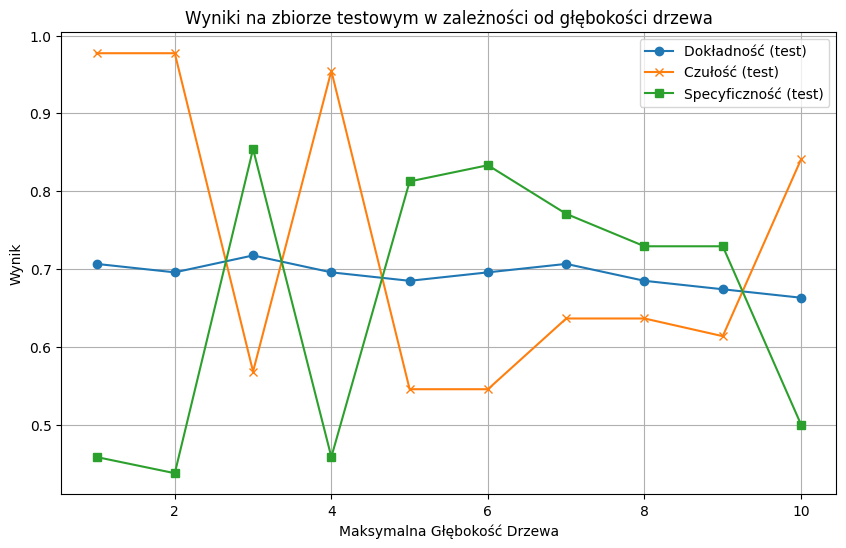

In [ ]:

# Wykres
plt.figure(figsize=(10, 6))
plt.plot(max_depths, accuracies_test, marker='o', label='Dokładność (test)')
plt.plot(max_depths, recalls, marker='x', label='Czułość (test)')
plt.plot(max_depths, specificities, marker='s', label='Specyficzność (test)')
plt.xlabel('Maksymalna Głębokość Drzewa')
plt.ylabel('Wynik')
plt.title('Wyniki na zbiorze testowym w zależności od głębokości drzewa')
plt.legend()
plt.grid(True)
plt.show()

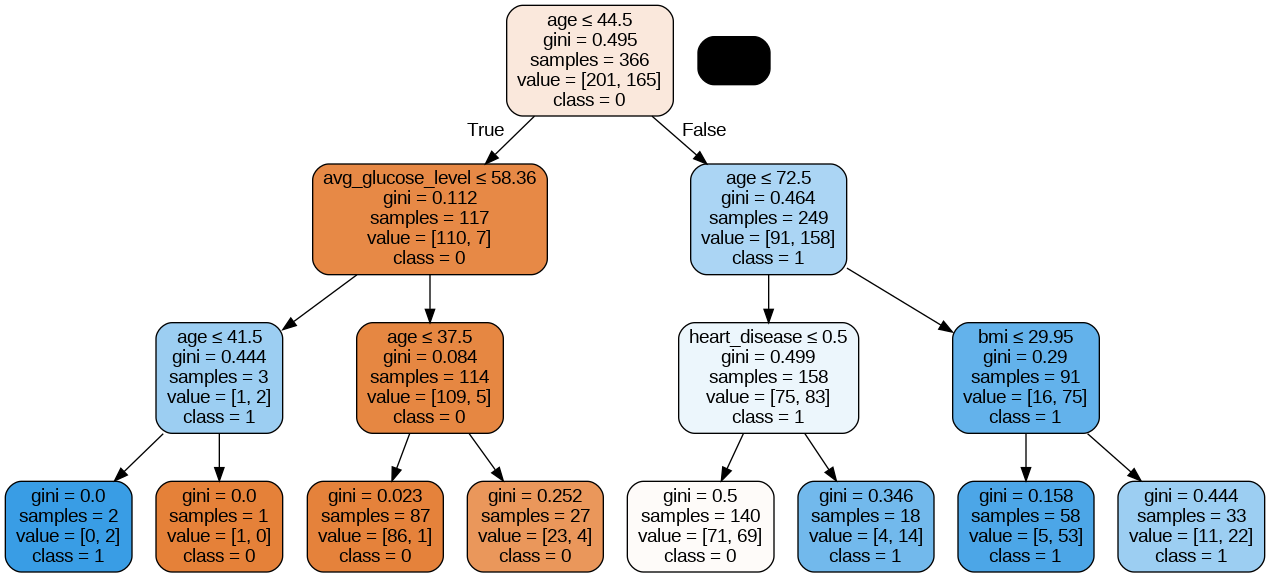

In [ ]:
# Tworzenie modelu drzewa decyzyjnego (zakładam, że "model" to Twój wytrenowany model)
model = DecisionTreeClassifier(max_depth=3)
model.fit(X_train, y_train)



# Przekształć etykiety klas na ciągi znaków
class_names = [str(c) for c in model.classes_]

# Generowanie opisu wizualizacji drzewa decyzyjnego
dot_data = export_graphviz(model, out_file=None,
                           feature_names=list(X_train.columns),
                           class_names=class_names,
                           filled=True, rounded=True, special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

#Porównanie parametrów dla indeksu Giniego oraz Entropii

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Tworzenie modelu drzewa decyzyjnego z indeksem Giniego
model_gini = DecisionTreeClassifier(max_depth=3, criterion="gini")
model_gini.fit(X_train, y_train)

# Tworzenie modelu drzewa decyzyjnego z entropią
model_entropy = DecisionTreeClassifier(max_depth=3, criterion="entropy")
model_entropy.fit(X_train, y_train)

# Predykcja na zbiorze testowym dla obu modeli
y_pred_gini = model_gini.predict(X_test)
y_pred_entropy = model_entropy.predict(X_test)

# Ocena wyników dla obu modeli
accuracy_gini = accuracy_score(y_test, y_pred_gini)
accuracy_entropy = accuracy_score(y_test, y_pred_entropy)

report_gini = classification_report(y_test, y_pred_gini)
report_entropy = classification_report(y_test, y_pred_entropy)

# Wyświetlenie wyników
print("Wyniki dla modelu z indeksem Giniego:")
print("Dokładność:", accuracy_gini)
print("Raport klasyfikacyjny:")
print(report_gini)

print("\nWyniki dla modelu z entropią:")
print("Dokładność:", accuracy_entropy)
print("Raport klasyfikacyjny:")
print(report_entropy)


Wyniki dla modelu z indeksem Giniego:
Dokładność: 0.7065217391304348
Raport klasyfikacyjny:
              precision    recall  f1-score   support

           0       0.68      0.83      0.75        48
           1       0.76      0.57      0.65        44

    accuracy                           0.71        92
   macro avg       0.72      0.70      0.70        92
weighted avg       0.72      0.71      0.70        92


Wyniki dla modelu z entropią:
Dokładność: 0.7065217391304348
Raport klasyfikacyjny:
              precision    recall  f1-score   support

           0       0.68      0.83      0.75        48
           1       0.76      0.57      0.65        44

    accuracy                           0.71        92
   macro avg       0.72      0.70      0.70        92
weighted avg       0.72      0.71      0.70        92



In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Definicja zbioru parametrów do przeszukania
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [ 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
}

# Inicjalizacja modelu drzewa decyzyjnego
tree_classifier = DecisionTreeClassifier(random_state=6)

# Użycie GridSearchCV do znalezienia najlepszych parametrów
grid_search = GridSearchCV(tree_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Wybieramy najlepsze parametry
best_tree = grid_search.best_estimator_

# Wyświetlenie najlepszych parametrów
print("Najlepsze parametry dla drzewa decyzyjnego:")
print(grid_search.best_params_)

# Dokładność modelu na zbiorze testowym
accuracy = best_tree.score(X_test, y_test)
print("Dokładność na zbiorze testowym:", accuracy)


Najlepsze parametry dla drzewa decyzyjnego:
{'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
Dokładność na zbiorze testowym: 0.6956521739130435


# Bagging

In [ ]:
decision_tree_b = DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=8, min_samples_split=2)

Definiowanie różnej liczby drzew i ocena wyników dla każdej z grup

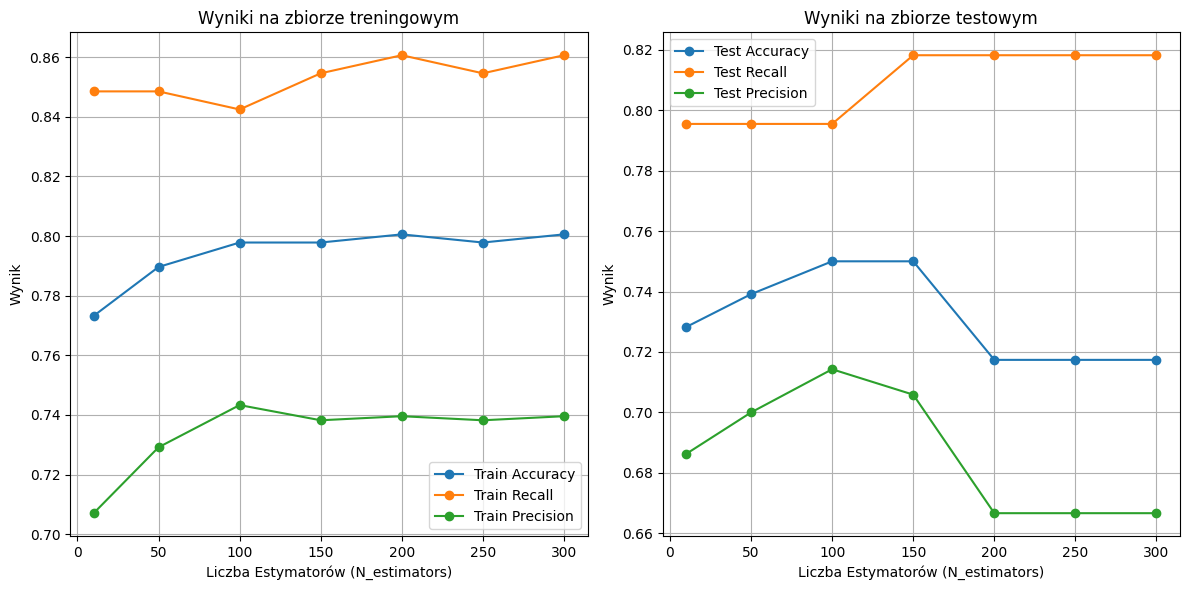

In [ ]:
# Lista liczby estymatorów do przetestowania
num_estimators = [10, 50, 100, 150, 200, 250, 300]

# Listy do przechowywania wyników na zbiorze treningowym
train_accuracy_scores = []
train_recall_scores = []
train_precision_scores = []

# Listy do przechowywania wyników na zbiorze testowym
test_accuracy_scores = []
test_recall_scores = []
test_precision_scores = []

for n_estimators in num_estimators:
    bagging_classifier = BaggingClassifier(estimator=decision_tree_b, n_estimators=n_estimators, random_state=10)
    bagging_classifier.fit(X_train, y_train)

    # Wyniki na zbiorze treningowym
    y_train_pred = bagging_classifier.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred)

    # Wyniki na zbiorze testowym
    y_test_pred = bagging_classifier.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)

    # Dodanie wyników do odpowiednich list
    train_accuracy_scores.append(train_accuracy)
    train_recall_scores.append(train_recall)
    train_precision_scores.append(train_precision)

    test_accuracy_scores.append(test_accuracy)
    test_recall_scores.append(test_recall)
    test_precision_scores.append(test_precision)

# Wykresy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Pierwszy wykres - wyniki na zbiorze treningowym
plt.plot(num_estimators, train_accuracy_scores, marker='o', label='Train Accuracy(dokładność)')
plt.plot(num_estimators, train_recall_scores, marker='o', label='Train Recall(czułość)')
plt.plot(num_estimators, train_precision_scores, marker='o', label='Train Precision(precyzja)')
plt.title('Wyniki na zbiorze treningowym')
plt.xlabel('Liczba Estymatorów (N_estimators)')
plt.ylabel('Wynik')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)  # Drugi wykres - wyniki na zbiorze testowym
plt.plot(num_estimators, test_accuracy_scores, marker='o', label='Test Accuracy(dokładność)')
plt.plot(num_estimators, test_recall_scores, marker='o', label='Test Recall(czułość)')
plt.plot(num_estimators, test_precision_scores, marker='o', label='Test Precision(precyzja)')
plt.title('Wyniki na zbiorze testowym')
plt.xlabel('Liczba Estymatorów (N_estimators)')
plt.ylabel('Wynik')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Najlepsza liczba próbek do budowy jednego drzewa: 0.8
Najlepsza dokładność na zbiorze testowym: 0.75
Czułość dla najlepszych parametrów: 0.8181818181818182
Precyzja dla najlepszych parametrów: 0.7058823529411765


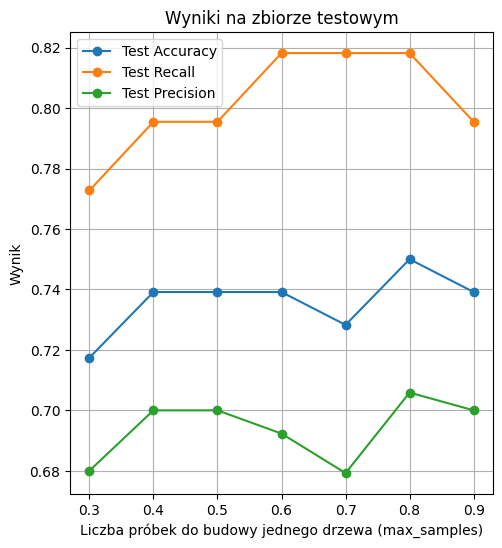

In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score

# Lista liczby próbek wykorzystywanych do budowy jednego drzewa
max_samples_values = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Lista do przechowywania wyników
test_accuracy_scores = []
test_recall_scores = []
test_precision_scores = []

for max_samples in max_samples_values:
    bagging_classifier = BaggingClassifier(estimator=decision_tree_b, n_estimators=150, max_samples=max_samples, random_state=10)
    bagging_classifier.fit(X_train, y_train)

    # Wyniki na zbiorze testowym
    y_test_pred = bagging_classifier.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)

    test_accuracy_scores.append(test_accuracy)
    test_recall_scores.append(test_recall)
    test_precision_scores.append(test_precision)

# Wykresy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Pierwszy wykres - wyniki na zbiorze testowym
plt.plot(max_samples_values, test_accuracy_scores, marker='o', label='Test Accuracy')
plt.plot(max_samples_values, test_recall_scores, marker='o', label='Test Recall')
plt.plot(max_samples_values, test_precision_scores, marker='o', label='Test Precision')
plt.title('Wyniki na zbiorze testowym')
plt.xlabel('Liczba próbek do budowy jednego drzewa (max_samples)')
plt.ylabel('Wynik')
plt.legend()
plt.grid(True)

# Analiza wyników i wybór najlepszych parametrów
best_max_samples = max_samples_values[test_accuracy_scores.index(max(test_accuracy_scores))]
best_accuracy = max(test_accuracy_scores)
best_recall = test_recall_scores[max_samples_values.index(best_max_samples)]
best_precision = test_precision_scores[max_samples_values.index(best_max_samples)]

print(f'Najlepsza liczba próbek do budowy jednego drzewa: {best_max_samples}')
print(f'Najlepsza dokładność na zbiorze testowym: {best_accuracy}')
print(f'Czułość dla najlepszych parametrów: {best_recall}')
print(f'Precyzja dla najlepszych parametrów: {best_precision}')

plt.show()
